# <center> Лабораторная работа 1.  </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
### Необходимо предсказывать пол клиента, основываясь на его транзакционных исторических данных. 

###История транзакция находится на сайте [Kaggle](https://www.kaggle.com/c/python-and-analyze-data-final-project/data)

### Вы будете строить предиктивные модели и отправлять результаты своего моделирования на платформу [Kaggle](https://www.kaggle.com/t/e8a939488d274dab9051cce14d5ca952), где и будет оцениваться каждое решение и положение участников. 
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

### Ваганова Анна, группа 20223

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive




---



Загрузим наборы данных

* transactions.csv - таблица содержит историю транзакций клиентов банка за один год и три месяца.
* gender_train.csv - таблица содержит информацию по полу для части клиентов, для которых он известен.
* tr_mcc_codes.csv - таблица содержит описание mcc-кодов транзакций.
* tr_types.csv - таблица содержит описание типов транзакций.
*gender_test_kaggle_sample_submission.csv - пример файла для загрузки решения.

In [ ]:
dir = '/content/drive/My Drive/neuralNetworkCourse/1/'

In [ ]:
train_genders = pd.read_csv(dir+'gender_train.csv', index_col='customer_id')

In [ ]:
transactions = pd.read_csv(dir+'transactions.csv').join(train_genders, how='left', on='customer_id')

In [ ]:
tr_mcc_codes = pd.read_csv(dir+'tr_mcc_codes.csv', sep=';', index_col='mcc_code')

In [ ]:
sample_submission = pd.read_csv(dir+'gender_test_kaggle_sample_submission.csv')

In [ ]:
train_customer_ids = set(train_genders.index)
train_male_customer_ids = set(train_genders[train_genders.gender == 1].index)
train_female_customer_ids = set(train_genders[train_genders.gender == 0].index)
test_customer_ids = set(sample_submission.customer_id)
all_customer_ids = train_customer_ids.union(test_customer_ids)

В transactions есть пользователи, которых нет ни в трейне (gender_train.csv), ни в тесте (sample_submission.csv). Видимо это те, кто не указал пол, удаляем.

In [ ]:
transactions = transactions[transactions.customer_id.isin(all_customer_ids)]

In [ ]:
train_genders.gender.value_counts(dropna=False)

0    4687
1    3713
Name: gender, dtype: int64



---



В качестве признаков используем информацию о типах покупок. Получим таблицу mcc_stats, где строка - ID пользователя, столбец - тип товара, значение - насколько часто покупал пользователь этот товар

In [ ]:
mcc_stats = transactions[transactions.amount < 0].groupby('customer_id') \
    .apply(lambda x: x['mcc_code'].value_counts().reindex(tr_mcc_codes.index)) \
    .fillna(0).astype(int)

In [ ]:
customer_ids_to_add = all_customer_ids.difference(set(mcc_stats.index))

In [ ]:
for customer_id in customer_ids_to_add:
  mcc_stats.loc[customer_id] = [0]*len(mcc_stats.columns)

In [ ]:
mcc_stats = mcc_stats.clip(0, 5) / 5
mcc_stats.shape

(12000, 184)

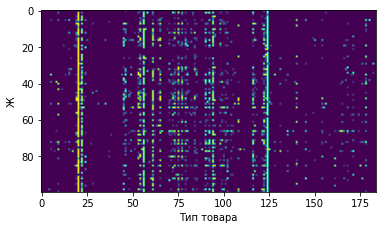

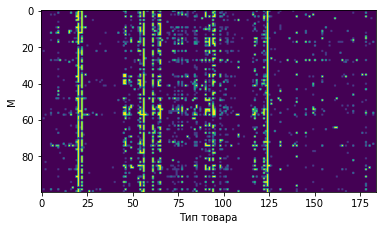

In [ ]:
plt.imshow(mcc_stats.loc[train_female_customer_ids][:100])
plt.xlabel('Тип товара')
plt.ylabel('Ж')
plt.show()

plt.imshow(mcc_stats.loc[train_male_customer_ids][:100])
plt.xlabel('Тип товара')
plt.ylabel('М')
plt.show()



---



Теперь предскажем и проверим точность

In [ ]:
X_train = mcc_stats.loc[train_customer_ids].to_numpy()
y_train = train_genders.loc[train_customer_ids].gender.to_numpy()
X_test = mcc_stats.loc[test_customer_ids].to_numpy()

In [ ]:
X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.33)

Наивный байесовский классификатор:

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X1, y1)
print(roc_auc_score(y2, model.predict_proba(X2)[:, 1]))

0.7230330801422192


Линейный дискриминант:

In [ ]:
model = LinearDiscriminantAnalysis()
model.fit(X1, y1)
print(roc_auc_score(y2, model.predict_proba(X2)[:, 1]))

0.8370583526312749


Квадратичный дискриминант:

In [ ]:
model = QuadraticDiscriminantAnalysis()
model.fit(X1, y1)
print(roc_auc_score(y2, model.predict_proba(X2)[:, 1]))

0.7323342377008404


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Метод опорных векторов линейный:

In [ ]:
model = svm.SVC(kernel='linear')
model.fit(X1, y1)
print(roc_auc_score(y2, model.predict(X2)))

0.7281604783452459




---



Метод опорных векторов квадратичный:

In [ ]:
model = svm.SVC(kernel='poly', degree=2)
model.fit(X1, y1)
print(roc_auc_score(y2, model.predict(X2)))

0.720333487504947


Деревья решений:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X1, y1)
print(roc_auc_score(y2, model.predict_proba(X2)[:, 1]))

0.6574370320216031


Градиентный бустинг:

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.3, max_depth = 6, alpha = 0, n_estimators = 100)
model.fit(X1,y1)
print(roc_auc_score(y2, model.predict(X2)))

0.8105718283428883


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(objective ='reg:squarederror')

clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='roc_auc',
                         n_iter=25,
                         verbose=1)
clf.fit(X1,y1)
print("Best parameters:", clf.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 40.9min finished


Best parameters: {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7999999999999999}


Best parameters: {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7999999999999999}

In [ ]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 6, n_estimators = 500, subsample=0.5, colsample_bylevel=0.8)
model.fit(X1,y1)
print(roc_auc_score(y2, model.predict(X2)))

0.8430405821011524


В итоге наилучшим методом здесь признаем метод: линейный дискриминант

In [ ]:
model = LinearDiscriminantAnalysis()
model.fit(X1, y1)
print(roc_auc_score(y2, model.predict_proba(X2)[:, 1]))
result = model.predict_proba(X_test)[:, 1]

0.8479830882590759


In [ ]:
submit = pd.DataFrame()
submit['customer_id'] = list(test_customer_ids)
submit['probability'] = result
submit.to_csv(dir+'submission.csv', index=False)

In [ ]:
submit

,customer_id,probability
0,87851013,0.853423
1,47570953,0.315027
2,37945354,0.057785
3,87695373,0.400470
4,66838542,0.893774
...,...,...
3595,88154104,0.456844
3596,88727545,0.388397
3597,58023930,0.673399
3598,58040316,0.279475


Сохраним файл для отправки в Kaggle

In [ ]:
files.download(dir+'submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

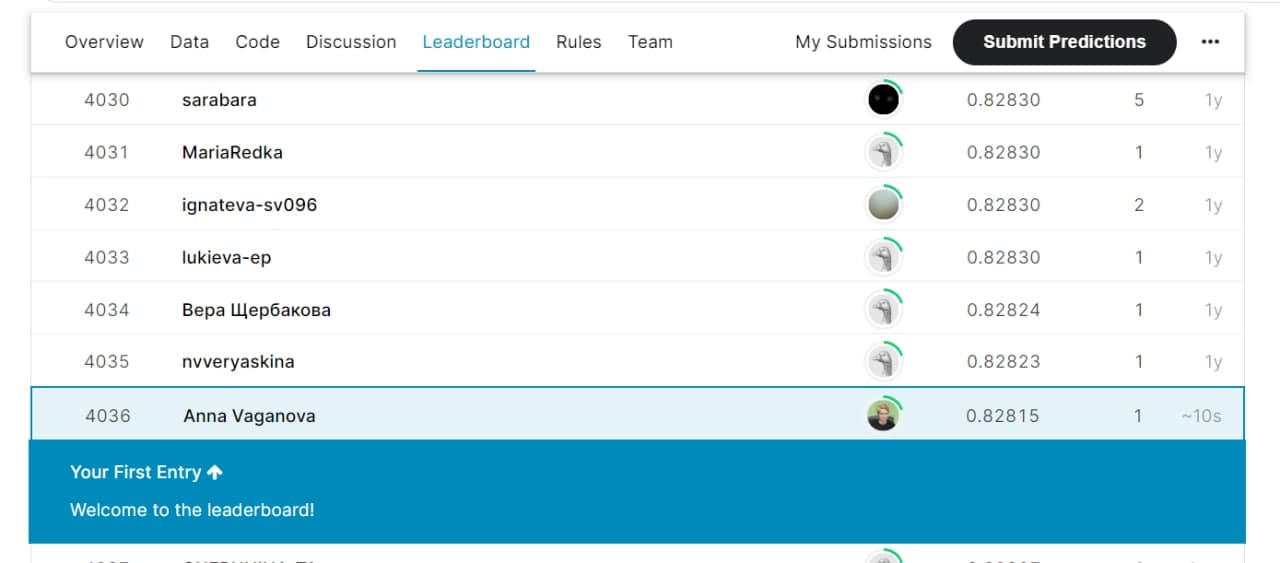



---

